In [ ]:
import os
from pathlib import Path
import random
from shutil import move

from glob import glob
from tqdm import tqdm
import cv2 as cv
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

#Questão 1

Usando a plataforma Kaggle, pesquise um base supervisionada de imagens que possa ser usada para treinar um classificador binário de imagens. Esta base deve conter exemplos de duas classes. Considere 70% das amostras para treino, e 30% para teste (m ́etodo holdout).

#### Setting dataset preferences

In [ ]:
# dataset link https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/

!echo "Baixando Dataset..."
!gdown -qq 17yRLKUa0lJZEu-3sh9Ai84YbMf5fYmFE

!echo "Configurando estrutura de pastas..."
!mkdir -p /content/data/q1
!unzip -qq /content/dataset_q1.zip -d /content/data/q1

!rm -r /content/dataset_q1.zip

!echo "Obtenção dos dados finalizada!"

Baixando Dataset...
Configurando estrutura de pastas...
Obtenção dos dados finalizada!


In [ ]:
images_train_cat = glob("/content/data/q1/train-cat-rabbit/cat/*.jpg", recursive=True)
images_train_rabbit = glob("/content/data/q1/train-cat-rabbit/rabbit/*.jpg", recursive=True)

cat_choices = random.sample(images_train_cat, 91)
rabbit_choices = random.sample(images_train_rabbit, 91)

folder_test_cat = Path("/content/data/q1/test-images/cat")
folder_test_rabbit = Path("/content/data/q1/test-images/cat")

for img_cat, img_rab in zip(cat_choices, rabbit_choices):

  img_cat = Path(img_cat)
  img_rab = Path(img_rab)

  move(img_cat, folder_test_cat / img_cat.name)
  move(img_rab, folder_test_rabbit / img_rab.name)

images_val = glob("/content/data/q1/val-cat-rabbit/**/*.jpg", recursive=True)
images_test = glob("/content/data/q1/test-images/**/*.jpg", recursive=True)

for img in images_val:

  move(
      img,
      img.replace("val-cat-rabbit", "test-images")
  )

In [ ]:
!rm -r /content/data/q1/val-cat-rabbit
!mv /content/data/q1/test-images /content/data/q1/test-cat-rabbit

#### a) <br>
Usando OpenCV, extraia descritores HOG (Histogram of Gradi-
ents), e treine um classificador SVM. Exiba a acurácia atingida no conjunto
de teste e a matriz de confusão. Exiba exemplos. Obs.: note que essa abordagem é semelhante ao detector Dalal-Triggs, porém aqui estamos usando-a
para classificação de imagens.

##### Hog + SVM classifier

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from skimage.feature import hog
from sklearn.svm import SVC
import numpy as np



Acurácia:  0.7096219931271478

Matriz de confusão



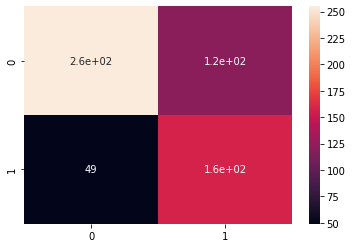

In [ ]:
def show_metrics(test_set, preds):

  print(f"\n\nAcurácia:  {accuracy_score(test_set, preds)}\n")
  print("Matriz de confusão\n")
  cm = confusion_matrix(test_set, preds)
  sns.heatmap(cm, annot=True)

def deskew(img, imgSize):
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5*imgSize*skew], [0, 1, 0]])
    img = cv.warpAffine(img, M, (imgSize, imgSize), flags=cv.WARP_INVERSE_MAP | cv.INTER_LINEAR)
    return img

def load_data(folder, imsize, hog):
  
  images = []
  labels = []
  descritors = []

  for i, path in enumerate(folder.glob("**/*.jpg")):

    image = cv.imread(str(path))
    image = cv.resize(image, (224, 224))
    images.append(image)

    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = deskew(image, imsize)
    descriptor = hog.compute(image)
    
    descritors.append(descriptor)
    labels.append(0 if path.parent.stem == "cat" else 1)

  descritors = np.resize(descritors, (len(descritors), len(descritors[0])))
  return np.array(images), np.array(labels), np.array(descritors)

def get_hog_descritor(imsize=224):

  winSize = (imsize, imsize)
  blockSize = (imsize//2, imsize//2) 
  cellSize = (imsize//2, imsize//2)
  blockStride = (imsize//4, imsize//4)

  nbins = 9
  signedGradients = True
  derivAperture = 1
  winSigma = -1.0

  histogramNormType = 0
  L2HysThreshold = 0.5
  gammaCorrection = 1
  nlevels = 64

  return cv.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma, 
                          histogramNormType, L2HysThreshold, gammaCorrection, nlevels, signedGradients)


imgsz = 224

hog = get_hog_descritor(imgsz)
train_images, train_labels, train_descriptors = load_data(Path("/content/data/q1/train-cat-rabbit"), imgsz, hog)
test_images, test_labels, test_descriptors = load_data(Path("/content/data/q1/test-cat-rabbit"), imgsz, hog)


clf = SVC(C=1.0, kernel='rbf')
clf.fit(train_descriptors, train_labels)

predictions_hog = clf.predict(test_descriptors)
show_metrics(np.array(test_labels), predictions_hog)

In [ ]:
samples_idxs_plot = choices = random.sample(range(len(test_images)), 18)

##### Useful functioins

In [ ]:
def hog_process_input(x):
  image = cv.cvtColor(x, cv.COLOR_BGR2GRAY)
  image = deskew(image, 224)
  feature = hog.compute(image)
  return np.resize(feature, (1,81))

def CNNs_outputs(x):
    return 0 if x < 0.5 else 1

def plot_some_samples(model, test_samples, process_input, process_output, mode='cnn'):

  labels = {
      0: 'cat',
      1: 'rabbit'
  }

  figure = plt.figure(figsize=(15, 8))
  for j, i in enumerate(samples_idxs_plot):

      current_image = test_samples[i]

      if mode == 'cnn':
        current_image = current_image.reshape(1, 224, 224, 3)

      current_image = process_input(current_image)
      prediction = model.predict(current_image)

      plt.subplot(3, 6, j+1)
      plt.imshow(cv.cvtColor(test_samples[i], cv.COLOR_BGR2RGB))

      pred = process_output(prediction)
      plt.title(labels[pred])
      plt.axis("off")
  
  plt.show()

##### Plots some samples to HOG+SVM classifier

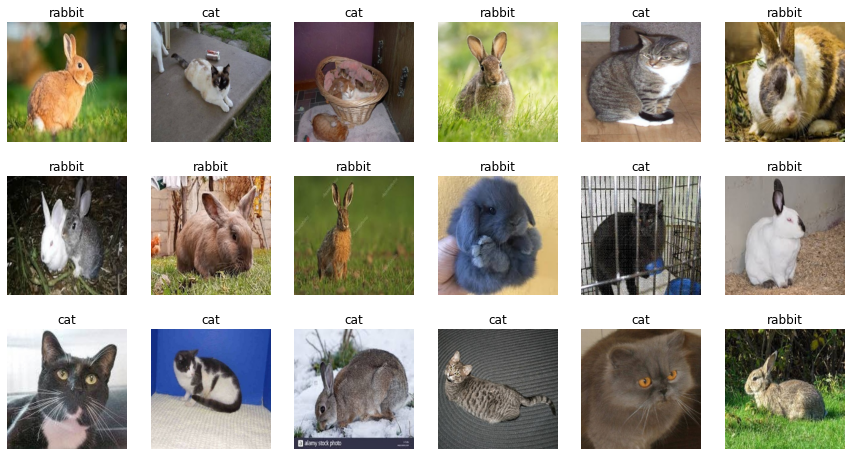

In [ ]:
#Showing some samples using HOG+SVM trained classifier

hog_process_ouput = lambda x: x[0]
plot_some_samples(clf, test_images, hog_process_input, hog_process_ouput, 'hog')

### b)

Agora o objetivo é treinar uma CNN. Usando a abordagem de
transferência de aprendizado (transfer learning), realize treinamentos usandomodelos VGG16, ResNet50, e MobileNetV2 pré-treinados. Compare os resultados usando acurácias e matrizes de confusão. Exiba exemplos.

##### Imports

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

##### Utility functions

In [ ]:
def apply_model(base_model, train, test):

  base_model.trainable = False

  model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.6),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid'),
  ])
  
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  model.fit(train[0], train[1], epochs=5)

  predictions = []
  predictions = model.predict(test[0])
  predictions = list(map(CNNs_outputs, list(predictions)))

  show_metrics(test[1], predictions)

  return model

#####VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

58900480/58889256 [==============================] - 1s 0us/step
Epoch 1/5
45/45 [==============================] - 22s 177ms/step - loss: 8.5800 - acc: 0.8949
Epoch 2/5
45/45 [==============================] - 7s 152ms/step - loss: 2.3754 - acc: 0.9767
Epoch 3/5
45/45 [==============================] - 7s 157ms/step - loss: 2.6288 - acc: 0.9788
Epoch 4/5
45/45 [==============================] - 7s 154ms/step - loss: 1.6619 - acc: 0.9845
Epoch 5/5
45/45 [==============================] - 7s 156ms/step - loss: 0.4949 - acc: 0.9951


Acurácia:  0.8281786941580757

Matriz de confusão



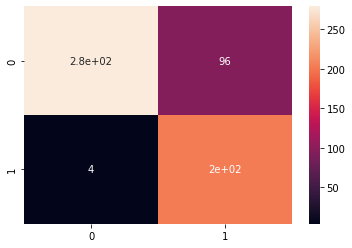

In [ ]:
vgg_train_samples = vgg_preprocess(train_images)

vgg_backbone = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
vgg_model = apply_model(vgg_backbone, (vgg_train_samples, train_labels), (test_images, test_labels))

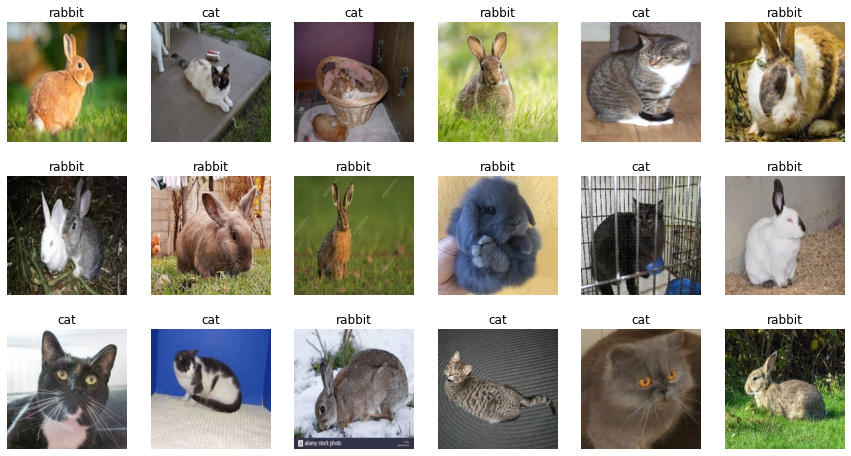

In [ ]:
plot_some_samples(vgg_model, test_images, vgg_preprocess, CNNs_outputs)

#### Resnet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/5
45/45 [==============================] - 10s 124ms/step - loss: 3.6664 - acc: 0.9386
Epoch 2/5
45/45 [==============================] - 5s 114ms/step - loss: 2.5641 - acc: 0.9810
Epoch 3/5
45/45 [==============================] - 5s 115ms/step - loss: 2.2738 - acc: 0.9845
Epoch 4/5
45/45 [==============================] - 5s 120ms/step - loss: 1.3834 - acc: 0.9908
Epoch 5/5
45/45 [==============================] - 5s 118ms/step - loss: 0.6271 - acc: 0.9937


Acurácia:  0.8384879725085911

Matriz de confusão



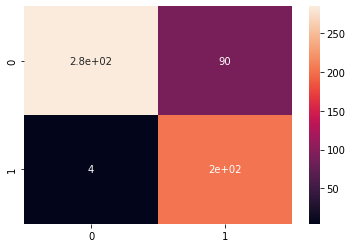

In [ ]:
resnet_train_samples = resnet_preprocess(train_images)

resnet_backbone = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
resnet_model = apply_model(resnet_backbone, (resnet_train_samples, train_labels), (test_images, test_labels))

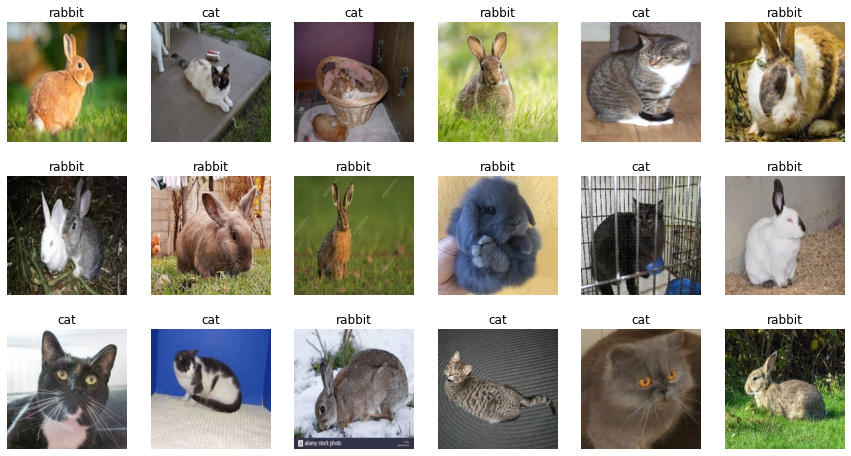

In [ ]:
# Showing some samples using Resnet50 trained classifier
plot_some_samples(resnet_model, test_images, resnet_preprocess, CNNs_outputs)

#### MobileNetV2

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess

17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/5
45/45 [==============================] - 5s 56ms/step - loss: 4.0681 - acc: 0.9118
Epoch 2/5
45/45 [==============================] - 2s 51ms/step - loss: 0.6333 - acc: 0.9824
Epoch 3/5
45/45 [==============================] - 2s 50ms/step - loss: 0.9071 - acc: 0.9824
Epoch 4/5
45/45 [==============================] - 2s 50ms/step - loss: 0.7639 - acc: 0.9873
Epoch 5/5
45/45 [==============================] - 2s 50ms/step - loss: 0.1743 - acc: 0.9972


Acurácia:  0.6443298969072165

Matriz de confusão



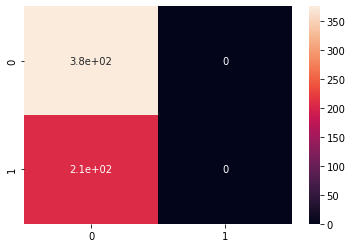

In [ ]:
mobile_train_samples = mobile_preprocess(train_images)

mobile_backbone = MobileNet(weights="imagenet", include_top=False, input_shape=(224,224,3))
mobile_model = apply_model(mobile_backbone, (mobile_train_samples, train_labels), (test_images, test_labels))

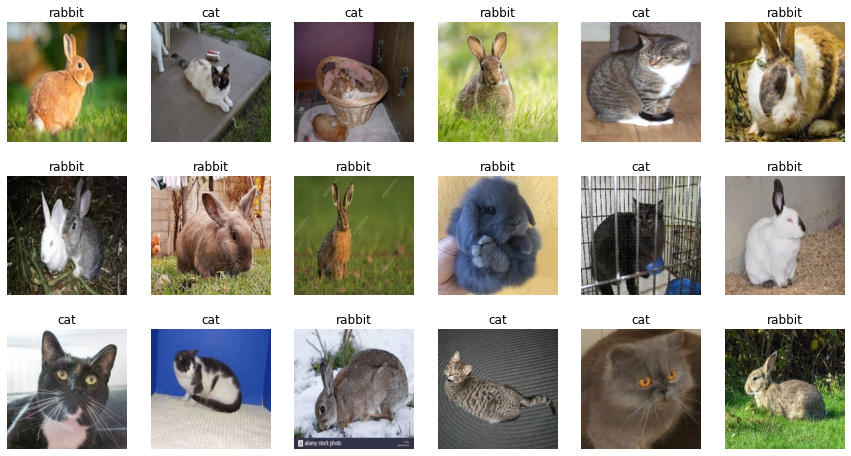

In [ ]:
plot_some_samples(mobile_model, test_images, mobile_preprocess, CNNs_outputs)

#Questão 2

##### Import yolov5 model from torch hub

In [ ]:
import torch
import warnings
import cv2 as cv
from shutil import rmtree

%matplotlib inline

warnings.filterwarnings('ignore')

#https://docs.ultralytics.com/tutorials/pytorch-hub/
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s')

##### a)

##### Plotting samples detections to 3 images

In [ ]:
!rm -r /content/data/q2
!mkdir -p /content/data/q2
!curl -s https://imagens.mdig.com.br/thbs/45184mn.jpg -o /content/data/q2/cats.jpg
!curl -s "https://nuoitrong123.com/wp-content/uploads/2015/07/dac-diem-sinh-truong-phat-trien-cua-tho.jpg" -o /content/data/q2/img1.jpg
!curl -s https://blog.myfitnesspal.com/wp-content/uploads/2020/01/10-Healthy-Habits-of-People-Who-Walk-Every-Day-2-752x472.jpg -o /content/data/q2/img2.jpg

Saved 1 image to runs/detect/exp
Saved 1 image to runs/detect/exp2
Saved 1 image to runs/detect/exp3


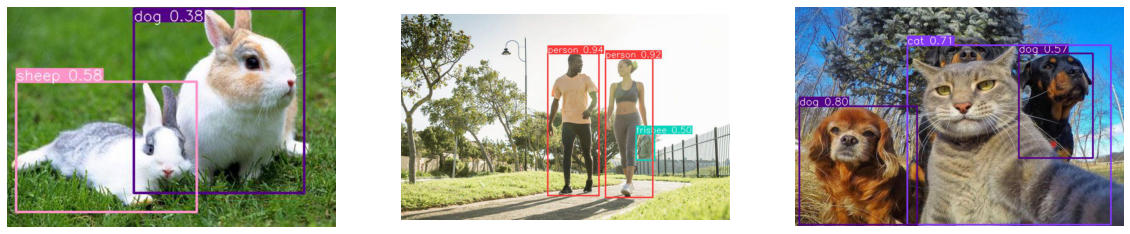

In [ ]:
%matplotlib inline

!rm -r /content/runs 

for path in Path("/content/data/q2").glob("*.jpg"):
    result = yolo(path)
    result.save()

plt.figure(figsize=(20, 12))

for i, path_det in enumerate(glob("runs/detect/exp*/*")):
  image_det = plt.imread(path_det)
  plt.subplot(1, 3, i+1)
  plt.imshow(image_det)
  plt.axis('off')

plt.show()

### b)

##### Plotting tragetory using detections boxes

In [ ]:
!mkdir -p /content/videos
!gdown 1tpnONL9b7Xl_EuIuudB7T8L7cAax2nZE --output /content/videos/video.mp4

Downloading...
From: https://drive.google.com/uc?id=1tpnONL9b7Xl_EuIuudB7T8L7cAax2nZE
To: /content/videos/video.mp4
100% 765k/765k [00:00<00:00, 141MB/s]


In [ ]:
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width = 600):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video muted width={video_width} controls><source src="{video_url}"></video>""")
 
show_video("/content/videos/video.mp4")

frames list contains 12 frames instances



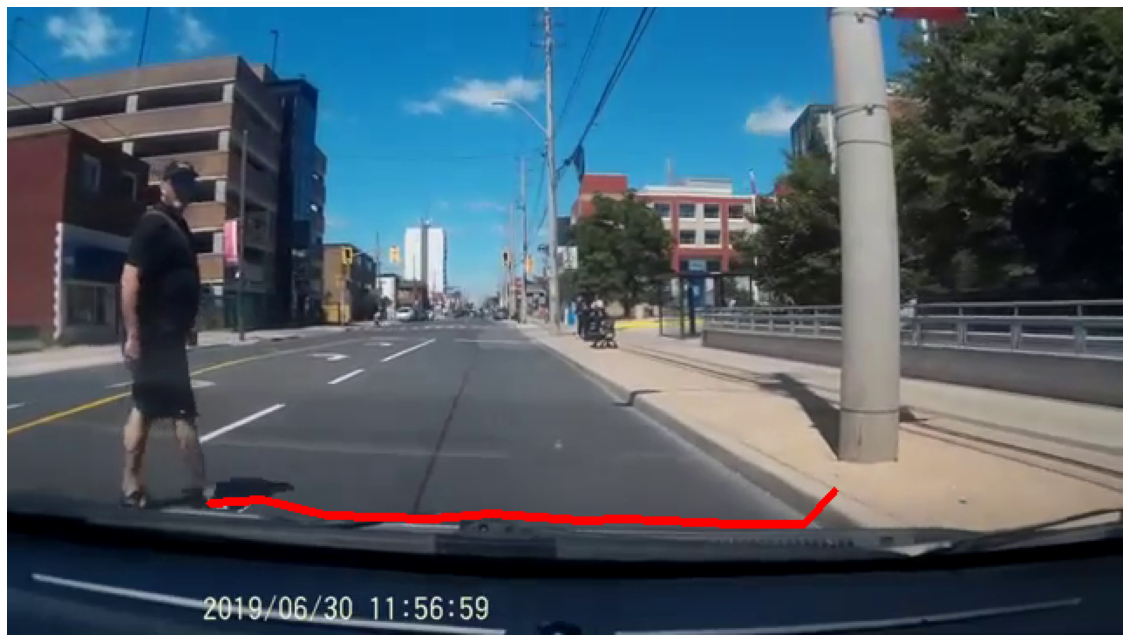

In [ ]:
def get_all_frames(video_path):
  '''
  This function return a list with frames from video
  '''
  images = []
  vidcap = cv.VideoCapture(video_path)
  count = 0
  while True:

    success = True
    success, image = vidcap.read()
    if not success:
      break
    images.append(cv.cvtColor(image, cv.COLOR_BGR2RGB)) #convert BGR image to RGB
    count+=1

  # 45 frame it's a nice start
  # step = 10 to get only spaced frames 
  return images[45:count-1:10], images[45]


frames, first_frame = get_all_frames("/content/videos/video.mp4")
print(f"frames list contains {len(frames)} frames instances\n")

points = []

for i, frame in enumerate(frames):
  result = yolo(frame) #applying yolo model to current frame
  df_detecs = result.pandas().xyxy[0]# .pandas() return a dataframe with xmin,ymin,xmax,ymax,confidence, class,name columns to each detection
  [x_min, y_min, x_max, y_max] = df_detecs.query('name == "person"').sort_values(by='confidence', ascending=False).values[0][:4]
  #the last query search for the most visible man in the video (black clothes man)  
  points.append((round(x_max), round(y_max))) #save (x_max, y_max) point to plot tragetory (image origin is (0,0) in top left)

for i in range(len(points)-1):

  start_point, end_point = points[i], points[i+1]
  first_frame = cv.line(first_frame, start_point, end_point, (255,0,0), 3)  

plt.figure(figsize=(20, 12))
plt.imshow(first_frame)
plt.axis("off")
  
plt.show()